In [1]:
import keras
import pickle
import numpy as np
import os
import glob
import pandas as pd
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import itertools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras import backend as K
from keras.layers import InputSpec
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from keras_tqdm import TQDMNotebookCallback
from keras.models import Model
from keras.layers import Dense, Dropout, Bidirectional, Input
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam, SGD
from keras import backend as K

Using TensorFlow backend.


In [ ]:
#!pip install keras_tqdm

### Read and load embeddings 

In [2]:
idx = 0
vocab = {}
with open(r"C:\Users\ΑΙ\Desktop\lab4_TA\cc.en.300.vec\cc.en.300.vec", encoding="utf-8", newline='\n',errors='ignore') as f:
    for l in f:
        line = l.rstrip().split(' ')
        if idx == 0:
            vocab_size = int(line[0]) + 1
            dim = int(line[1])
            vecs = np.zeros(vocab_size*dim).reshape(vocab_size,dim)
            vocab["__PADDING__"] = 0
            idx = 1
        else:
            vocab[line[0]] = idx
            emb = np.array(line[1:]).astype(np.float)
            if (emb.shape[0] == dim):
                vecs[idx,:] = emb
                idx+=1
            else:
                continue

    pickle.dump(vocab,open("fasttext_voc",'wb'))
    np.save("fasttext.npy",vecs)

In [3]:
fasttext_embed = np.load("fasttext.npy")
fasttext_word_to_index = pickle.load(open("fasttext_voc", 'rb'))

In [4]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))


def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)

### Read Enron dataset

In [5]:
def read_data(directory,file_extension,class_label):
    
    data = []
    index = []
    for filename in glob.glob(directory+'/**/*'+file_extension, recursive=True):
        email_content = ""
        with open(filename, 'r',encoding='utf-8', errors='ignore') as email:
            for line in email:
                line = line.strip('\n')
                line = line.strip('\t')
                email_content+= line
        email.close()
        data.append({'text': email_content, 'label': class_label})
        index.append(filename)
                    
    return data,index

In [6]:
Enron_dataset_dir = r"C:\Users\ΑΙ\Desktop\Enron_dataset"
Ham_data,index_hamdata = read_data(Enron_dataset_dir,".ham.txt","Ham")
Spam_data,index_spamdata = read_data(Enron_dataset_dir,".spam.txt","Spam")
data = pd.DataFrame(Ham_data,index =index_hamdata)
data = data.append(pd.DataFrame(Spam_data,index =index_spamdata))
#shufle dataframe
data = shuffle(data,random_state = 456987)
pd.set_option("max_colwidth",2000)
data

label  \
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron4\spam\1306.2004-05-29.GP.spam.txt         Spam   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron4\spam\0347.2004-02-05.GP.spam.txt         Spam   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron6\spam\2646.2005-01-11.BG.spam.txt         Spam   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron2\ham\3439.2000-11-27.kaminski.ham.txt      Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron3\ham\4567.2001-12-13.kitchen.ham.txt       Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron6\ham\3534.2001-05-02.lokay.ham.txt         Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron2\ham\0779.2000-03-19.kaminski.ham.txt      Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron6\spam\2574.2005-01-07.BG.spam.txt         Spam   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron6\ham\0381.2000-07-14.lokay.ham.txt         Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron5\spam\0498.2002-07-16.SA_and_HP.spam.txt  Spam   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron4\spam\5966.2005-09-03.GP.spam.txt         Spam   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron4\ham\5225.2002-01-23.williams.ham.txt      Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron2\ham\1669.2000-06-30.kaminski.ham.txt      Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron3\ham\4653.2001-12-20.kitchen.ham.txt       Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron4\spam\5363.2005-06-06.GP.spam.txt         Spam   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron2\spam\4834.2005-07-16.SA_and_HP.spam.txt  Spam   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron3\ham\2520.2001-09-14.kitchen.ham.txt       Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron3\ham\1977.2001-08-10.kitchen.ham.txt       Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron4\spam\3952.2005-01-18.GP.spam.txt         Spam   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron5\spam\5162.2005-07-22.SA_and_HP.spam.txt  Spam   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron1\ham\3786.2001-03-14.farmer.ham.txt        Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron1\ham\2862.2000-11-15.farmer.ham.txt        Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron1\ham\4416.2001-04-27.farmer.ham.txt        Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron3\ham\1219.2001-06-18.kitchen.ham.txt       Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron4\ham\0149.2001-04-16.williams.ham.txt      Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron2\spam\3033.2005-06-29.SA_and_HP.spam.txt  Spam   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron2\spam\2389.2005-06-24.SA_and_HP.spam.txt  Spam   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron2\ham\0451.2000-02-14.kaminski.ham.txt      Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron3\ham\0720.2001-04-20.kitchen.ham.txt       Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron4\ham\4731.2002-01-14.williams.ham.txt      Ham   
...                                                                                              ...   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron6\spam\2943.2005-01-22.BG.spam.txt         Spam   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron2\ham\2161.2000-08-11.kaminski.ham.txt      Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron5\spam\4445.2005-07-19.SA_and_HP.spam.txt  Spam   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron1\ham\1172.2000-05-30.farmer.ham.txt        Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron3\ham\3386.2001-10-25.kitchen.ham.txt       Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron2\ham\2416.2000-09-04.kaminski.ham.txt      Ham   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron6\spam\5119.2005-06-03.BG.spam.txt         Spam   
C:\Users\ΑΙ\Desktop\Enron_dataset\Enron

### Split dataset

In [7]:
import itertools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
train, test = train_test_split(data, test_size = 0.2,random_state=1596)
train, dev = train_test_split(train, test_size = 0.2,random_state=1596)

X_train = list(itertools.chain.from_iterable(train[['text']].values.tolist()))
X_dev = list(itertools.chain.from_iterable(dev[['text']].values.tolist()))
X_test = list(itertools.chain.from_iterable(test[['text']].values.tolist()))

y_train = list(itertools.chain.from_iterable(train[['label']].values.tolist()))
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_dev = le.transform(list(itertools.chain.from_iterable(dev[['label']].values.tolist())))
y_test = le.transform(list(itertools.chain.from_iterable(test[['label']].values.tolist())))

In [8]:
MAX_WORDS =20000
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)
train_seqs = tokenizer.texts_to_sequences(X_train)

dev_seqs = tokenizer.texts_to_sequences(X_dev)
test_seqs = tokenizer.texts_to_sequences(X_test)

train_data = pad_sequences(train_seqs, maxlen=MAX_SEQUENCE_LENGTH)
dev_data = pad_sequences(dev_seqs, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_seqs, maxlen=MAX_SEQUENCE_LENGTH)

In [9]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 238722 unique tokens.


In [10]:
word_index

{'the': 1,
 'to': 2,
 'and': 3,
 'of': 4,
 'a': 5,
 'in': 6,
 "'": 7,
 'for': 8,
 'you': 9,
 'is': 10,
 'this': 11,
 'on': 12,
 'enron': 13,
 'that': 14,
 'i': 15,
 's': 16,
 'be': 17,
 'with': 18,
 'your': 19,
 'subject': 20,
 'we': 21,
 'as': 22,
 'have': 23,
 'it': 24,
 'from': 25,
 'will': 26,
 'are': 27,
 'or': 28,
 'ect': 29,
 'at': 30,
 'by': 31,
 'not': 32,
 'our': 33,
 'if': 34,
 '1': 35,
 'company': 36,
 'all': 37,
 'an': 38,
 'com': 39,
 'has': 40,
 'hou': 41,
 '2': 42,
 'please': 43,
 'can': 44,
 'was': 45,
 '3': 46,
 'me': 47,
 'any': 48,
 'e': 49,
 'would': 50,
 'new': 51,
 'its': 52,
 'no': 53,
 'more': 54,
 '2001': 55,
 'but': 56,
 'my': 57,
 're': 58,
 'may': 59,
 't': 60,
 '5': 61,
 '10': 62,
 '2000': 63,
 'do': 64,
 'which': 65,
 'time': 66,
 'up': 67,
 'one': 68,
 'about': 69,
 'said': 70,
 'information': 71,
 'gas': 72,
 'out': 73,
 'been': 74,
 'they': 75,
 'us': 76,
 'energy': 77,
 'business': 78,
 'get': 79,
 '00': 80,
 'he': 81,
 '4': 82,
 'http': 83,
 '000': 8

### Initialize embeddings matrix

In [11]:
embedding_matrix = np.zeros((MAX_WORDS+1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_vector = fasttext_embed[fasttext_word_to_index[word],:]
        embedding_matrix[i] = embedding_vector
    except:
        pass

In [12]:
class AttentionWeightedAverage(Layer):

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.w = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_w'.format(self.name),
                                 initializer=self.init)
        self.trainable_weights = [self.w]
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, h, mask=None):
        h_shape = K.shape(h)
        d_w, T = h_shape[0], h_shape[1]
        
        logits = K.dot(h, self.w)  # w^T h
        logits = K.reshape(logits, (d_w, T))
        alpha = K.exp(logits - K.max(logits, axis=-1, keepdims=True))  # exp
        
        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            alpha = alpha * mask
        alpha = alpha / K.sum(alpha, axis=1, keepdims=True) # softmax
        r = K.sum(h * K.expand_dims(alpha), axis=1)  # r = h*alpha^T
        h_star = K.tanh(r)  # h^* = tanh(r)
        if self.return_attention:
            return [h_star, alpha]
        return h_star

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

Create function for parameter tuning

In [13]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K

def create_model(activation, hidden_layers=1):
    LSTM_SIZE = 100
    DENSE = 200
    N_CLASSES = 1

    model = Sequential()

    # Add fully connected layer with a ReLU activation function
    model.add(Embedding(MAX_WORDS+1, EMBEDDING_DIM, weights=[embedding_matrix], 
                    input_length=MAX_SEQUENCE_LENGTH,mask_zero=True, trainable=False))
    model.add(Dropout(0.5))
    # add a bidirectional lstm layer
    model.add(Bidirectional(LSTM(units=LSTM_SIZE, return_sequences=True)))
    model.add(AttentionWeightedAverage(return_attention=False))
    # Add fully connected hidden layers with a tuned activation function
    for i in range(hidden_layers):
        model.add(Dense(256,  activation=activation))
        model.add(Dropout(0.5))

    # Add fully connected layer with a sigmoid activation function
    model.add(Dense(units=N_CLASSES, activation="sigmoid"))

    # Compile neural network
    model.compile(loss='binary_crossentropy', 
                    optimizer='Adam', 
                    metrics=[accuracy,precision]) 
    
    # Return compiled network
    return model

In [14]:
# Create hyperparameter space
activation = ['relu', 'tanh']
hidden_layers=[1,3]

hyperparameters = dict(hidden_layers=hidden_layers,activation=activation)

Uncomment the following, to perform grid search

In [24]:
# Create grid search
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model)

grid = GridSearchCV(estimator=model,cv=StratifiedKFold(n_splits=4), param_grid=hyperparameters,scoring ='f1')

# # Fit grid search
grid_result = grid.fit(train_data, y_train)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1
 3968/16182 [======>.......................] - ETA: 36:40 - loss: 0.6910 - accuracy: 0.6250 - precision: 0.583 - ETA: 25:26 - loss: 0.6929 - accuracy: 0.5781 - precision: 0.291 - ETA: 21:41 - loss: 0.6894 - accuracy: 0.5625 - precision: 0.194 - ETA: 19:47 - loss: 0.6875 - accuracy: 0.5391 - precision: 0.145 - ETA: 18:38 - loss: 0.6812 - accuracy: 0.5625 - precision: 0.116 - ETA: 18:00 - loss: 0.6826 - accuracy: 0.5469 - precision: 0.263 - ETA: 17:29 - loss: 0.6832 - accuracy: 0.5312 - precision: 0.369 - ETA: 17:02 - loss: 0.6813 - accuracy: 0.5391 - precision: 0.447 - ETA: 16:41 - loss: 0.6846 - accuracy: 0.5243 - precision: 0.467 - ETA: 16:25 - loss: 0.6786 - accuracy: 0.5406 - precision: 0.499 - ETA: 16:10 - loss: 0.6769 - accuracy: 0.5568 - precision: 0.525 - ETA: 15:58 - loss: 0.6744 - accuracy: 0.5651 - precision: 0.532 - ETA: 15:47 - loss: 0.6740

In [30]:
print('The best parameters are:',grid_result.best_params_)
print(grid_result.best_score_)

The best parameters are: {'activation': 'tanh', 'hidden_layers': 3}
0.9593883894347196


In [31]:
pd.DataFrame(grid_result.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     891.433399      2.500217        93.788608        0.106559   
1     906.360039     12.935983        94.890254        0.254257   
2     931.491605     36.341589       100.228479        5.347073   
3     958.950711      9.746218       101.149288        1.972720   

  param_activation param_hidden_layers  \
0             relu                   1   
1             relu                   3   
2             tanh                   1   
3             tanh                   3   

                                       params  split0_test_score  \
0  {'activation': 'relu', 'hidden_layers': 1}           0.948073   
1  {'activation': 'relu', 'hidden_layers': 3}           0.956267   
2  {'activation': 'tanh', 'hidden_layers': 1}           0.957512   
3  {'activation': 'tanh', 'hidden_layers': 3}           0.958770   

   split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
0           0.936275           0.952627           0.941441         0.944604   
1           0.960086           0.943633           0.943482         0.950867   
2           0.957171           0.957870           0.935355         0.951977   
3           0.955950           0.962066           0.960767         0.959388   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.006240                4            0.956088            0.942730   
1        0.007433                3            0.959727            0.961960   
2        0.009600                2            0.962619            0.959430   
3        0.002306                1            0.966113            0.960526   

   split2_train_score  split3_train_score  mean_train_score  std_train_score  
0            0.954010            0.942089          0.948729         0.006366  
1            0.945186            0.942124          0.952249         0.008698  
2            0.961590            0.936939          0.955144         0.010574  
3            0.964022            0.962730          0.963348         0.002027

### Tune epochs

In [ ]:
activation_grid=grid_result.best_params_['activation']
hidden_layers_grid=grid_result.best_params_['hidden_layers']

In [19]:
LSTM_SIZE = 100
DENSE = 200
N_CLASSES = 1

model = Sequential()

# Add fully connected layer with a ReLU activation function
model.add(Embedding(MAX_WORDS+1, EMBEDDING_DIM, weights=[embedding_matrix], 
                input_length=MAX_SEQUENCE_LENGTH,mask_zero=True, trainable=False))
model.add(Dropout(0.5))
# add a bidirectional lstm layer
model.add(Bidirectional(LSTM(units=LSTM_SIZE, return_sequences=True)))
model.add(AttentionWeightedAverage(return_attention=False))
# Add fully connected hidden layers with a tuned activation function
for i in range(hidden_layers_grid):
    model.add(Dense(256,  activation=activation_grid))
    model.add(Dropout(0.5))

# Add fully connected layer with a sigmoid activation function
model.add(Dense(units=N_CLASSES, activation="sigmoid"))

# Compile neural network
model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=[accuracy,precision]) 


checkpoint = ModelCheckpoint('keras_BiGRU_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')

model.fit(train_data, y_train,
              batch_size=32,
              epochs=12,
              verbose = 0,
              callbacks=[checkpoint,TQDMNotebookCallback()],
              validation_data=(dev_data, y_dev),
              shuffle=True)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


C:\Users\F743~1\AppData\Local\conda\conda\envs\tensorflow_env\lib\site-packages\keras\callbacks.py:434: RuntimeWarning: Can save best model only with val_f1 available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


In [125]:
a=model.history.history['accuracy']
best_epoch=a.index(max(a))
print('The epoch with the best accuracy score of model is: ',best_epoch)

The epoch with the best accuracy score of model is:  11


### Evaluate on test set

In [31]:
y_prob=model.predict(test_data)
y_pred=[1 if x>0.5 else 0 for x in y_prob]

In [48]:
y_prob = y_prob.reshape(y_prob.shape[0],)

In [32]:
from sklearn.metrics import f1_score
f1_score(y_test,y_pred)

0.9835971223021583

In [33]:
scores=model.evaluate(test_data,y_test)
scores

6744/6744 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 

[0.05154439366769492, 0.9830960854092526, 0.976699102250141]

In [49]:
print("test data confusion matrix")
y_true = pd.Series(y_test, name='True')
y_probs = pd.Series(y_prob, name='Probability')


y_predict = pd.Series(y_pred, name='Predicted')
pd.crosstab(y_true, y_predict)

test data confusion matrix


Predicted     0     1
True                 
0          3212    80
1            34  3418

In [51]:
# test=test.reset_index()
test[(y_true!=y_predict) & (y_probs>0.9)]

level_0  \
11         11   
27         27   
513       513   
650       650   
753       753   
932       932   
1044     1044   
1091     1091   
1142     1142   
1410     1410   
1522     1522   
1750     1750   
1777     1777   
1828     1828   
1972     1972   
2252     2252   
2267     2267   
2315     2315   
2515     2515   
2560     2560   
2711     2711   
2716     2716   
2784     2784   
2835     2835   
3101     3101   
3240     3240   
3286     3286   
3642     3642   
3891     3891   
4133     4133   
4254     4254   
4491     4491   
4584     4584   
4904     4904   
5437     5437   
5563     5563   
5663     5663   
6401     6401   
6519     6519   
6715     6715   

                                                                                            index  \
11       C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron6\ham\5278.2002-01-10.lokay.ham.txt   
27    C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron2\ham\0762.2000-03-17.kaminski.ham.txt   
513      C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron6\ham\0306.2000-07-10.lokay.ham.txt   
650     C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron1\ham\3999.2001-03-26.farmer.ham.txt   
753       C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron5\ham\4348.2001-02-07.beck.ham.txt   
932     C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron1\ham\5023.2001-10-30.farmer.ham.txt   
1044    C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron1\ham\0177.2000-01-11.farmer.ham.txt   
1091    C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron1\ham\0344.2000-02-04.farmer.ham.txt   
1142   C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron3\ham\3597.2001-10-31.kitchen.ham.txt   
1410      C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron5\ham\4190.2001-01-25.beck.ham.txt   
1522  C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron4\ham\0142.2001-04-16.williams.ham.txt   
1750  C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron2\ham\3774.2000-12-19.kaminski.ham.txt   
1777   C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron3\ham\2014.2001-08-16.kitchen.ham.txt   
1828     C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron6\ham\5923.2002-03-19.lokay.ham.txt   
1972   C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron3\ham\2004.2001-08-15.kitchen.ham.txt   
2252    C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron1\ham\5100.2001-12-07.farmer.ham.txt   
2267   C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron3\ham\4207.2001-11-23.kitchen.ham.txt   
2315  C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron4\ham\4919.2002-01-18.williams.ham.txt   
2515    C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron1\ham\1026.2000-05-02.farmer.ham.txt   
2560  C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron2\ham\5336.2001-04-19.kaminski.ham.txt   
2711      C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron5\ham\0896.2000-05-02.beck.ham.txt   
2716   C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron3\ham\3014.2001-10-09.kitchen.ham.txt   
2784  C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron2\ham\2090.2000-08-08.kaminski.ham.txt   
2835   C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron3\ham\3048.2001-10-12.kitchen.ham.txt   
3101  C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron4\ham\1889.2001-08-03.williams.ham.txt   
3240    C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron1\ham\1006.2000-04-27.farmer.ham.txt   
3286    C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron1\ham\0314.2000-02-02.farmer.ham.txt   
3642    C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron1\ham\2694.2000-10-30.farmer.ham.txt   
3891    C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron1\ham\1523.2000-06-28.farmer.ham.txt   
4133   C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron3\ham\2383.2001-09-10.kitchen.ham.txt   
4254     C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron6\ham\1443.2000-10-16.lokay.ham.txt   
4491  C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron4\ham\1030.2001-0

In [41]:
test[(y_true!=y_predict) & (y_probs<0.1)]

level_0  \
258       258   
1214     1214   
1886     1886   
2600     2600   
2647     2647   
3021     3021   
3487     3487   
3621     3621   
5034     5034   
5119     5119   
5186     5186   

                                                                                               index  \
258   C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron5\spam\2563.2005-06-28.SA_and_HP.spam.txt   
1214         C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron1\spam\1489.2004-07-03.GP.spam.txt   
1886         C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron6\spam\0445.2004-09-02.BG.spam.txt   
2600         C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron4\spam\4140.2005-02-03.GP.spam.txt   
2647         C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron4\spam\3076.2004-11-10.GP.spam.txt   
3021         C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron6\spam\4689.2005-05-05.BG.spam.txt   
3487         C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron4\spam\5882.2005-08-22.GP.spam.txt   
3621         C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron4\spam\2515.2004-09-27.GP.spam.txt   
5034  C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron5\spam\4497.2005-07-19.SA_and_HP.spam.txt   
5119         C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron6\spam\4803.2005-05-13.BG.spam.txt   
5186         C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron6\spam\3291.2005-02-07.BG.spam.txt   

     label  \
258   Spam   
1214  Spam   
1886  Spam   
2600  Spam   
2647  Spam   
3021  Spam   
3487  Spam   
3621  Spam   
5034  Spam   
5119  Spam   
5186  Spam   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 text  
258                                                                                                                                                                                                                                                                                                                                                                                    

In [42]:
test[(y_probs>0.45) & (y_probs<0.55)]

level_0  \
51         51   
728       728   
995       995   
1550     1550   
1751     1751   
1811     1811   
2158     2158   
2673     2673   
3485     3485   
4636     4636   
5268     5268   
6032     6032   
6625     6625   

                                                                                               index  \
51           C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron6\spam\1148.2004-10-21.BG.spam.txt   
728   C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron2\spam\2847.2005-06-28.SA_and_HP.spam.txt   
995   C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron2\spam\0076.2002-02-10.SA_and_HP.spam.txt   
1550      C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron3\ham\1639.2001-07-18.kitchen.ham.txt   
1751     C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron2\ham\4482.2001-02-14.kaminski.ham.txt   
1811       C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron1\ham\0071.1999-12-27.farmer.ham.txt   
2158       C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron1\ham\3347.2001-01-15.farmer.ham.txt   
2673  C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron5\spam\0273.2002-05-23.SA_and_HP.spam.txt   
3485         C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron3\spam\1004.2004-10-21.BG.spam.txt   
4636         C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron4\spam\0366.2004-02-09.GP.spam.txt   
5268  C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron5\spam\2001.2005-06-24.SA_and_HP.spam.txt   
6032     C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron4\ham\2590.2001-08-29.williams.ham.txt   
6625        C:\Users\ΑΙ\Desktop\Enron_dataset\Enron_dataset\enron6\ham\4421.2001-09-04.lokay.ham.txt   

     label  \
51    Spam   
728   Spam   
995   Spam   
1550   Ham   
1751   Ham   
1811   Ham   
2158   Ham   
2673  Spam   
3485  Spam   
4636  Spam   
5268  Spam   
6032   Ham   
6625   Ham   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 text  
51                                                                                                       

### Learning Curves



dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'loss', 'accuracy', 'precision'])


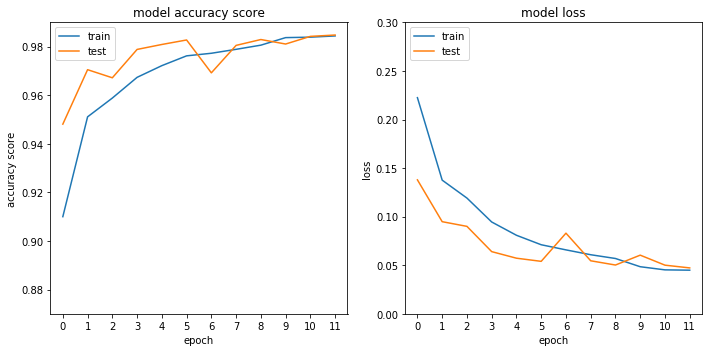

In [84]:
import matplotlib.pyplot as plt

print("\n")
print(model.history.history.keys())
plt.figure(figsize=(10, 5))
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy score')
plt.ylim(0.87,0.99)
plt.xlim(-0.5,11.5)
plt.xticks(np.arange(0,12, 1))
plt.ylabel('accuracy score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0.0,0.3)
plt.xlim(-0.5,11.5)
plt.xticks(np.arange(0,12, 1))
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

## Precision-recall curves 

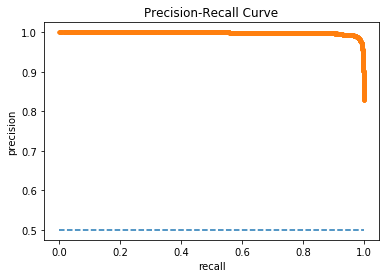

In [76]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
pyplot.plot(recall, precision, marker='.')
pyplot.xlabel('recall')
pyplot.ylabel('precision')
pyplot.title('Precision-Recall Curve')
pyplot.show()